In [172]:
df = pd.read_excel('wildfires.xlsx', sheet_name='Padre Island NS')[['CalendarYear', 'SizeClass']]
df.head(5)

,CalendarYear,SizeClass
0,1997,A
1,1997,B
2,1998,E
3,1998,D
4,1999,B


In [173]:
totalCount = df.groupby(['CalendarYear'])['CalendarYear'].count()
totalCount.head()

CalendarYear
1997    2
1998    2
1999    2
2001    2
2004    2
Name: CalendarYear, dtype: int64

C:\Users\kevin\AppData\Local\Temp\ipykernel_8976\2509795740.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


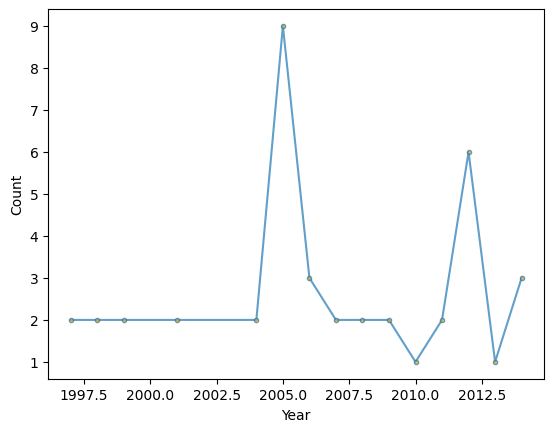

In [174]:
# Plot the sampled data
fig, ax = plt.subplots()
ax.plot(totalCount, ".-", ms=6, mfc="orange", alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
fig.show()

In [175]:
data = totalCount.to_numpy()
scores = list()
models = list()
for n_components in range(1, 4):
    for idx in range(10):  # ten different random starting states
        # define our hidden Markov model
        model = hmm.PoissonHMM(n_components=n_components, random_state=idx,
                               n_iter=10)
        model.fit(data[:, None])
        models.append(model)
        scores.append(model.score(data[:, None]))
      #   print(f'Converged: {model.monitor_.converged}\t\t'
      #         f'Score: {scores[-1]}')

# get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{model.n_components} components')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = model.predict(data[:, None])

The best model had a score of -25.994340306563895 and 3 components


Text(0.5, 0, 'State')

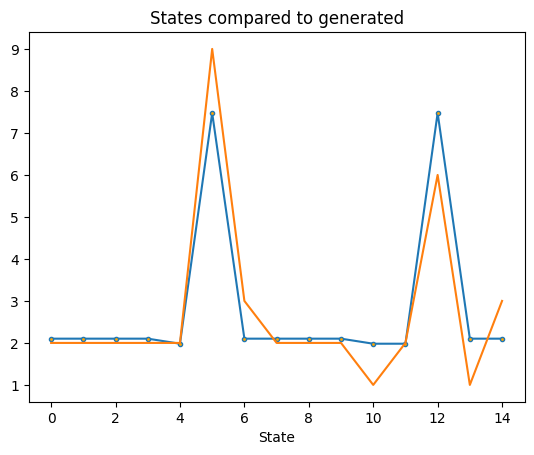

In [176]:
# plot model states over time
fig, ax = plt.subplots()
ax.plot(model.lambdas_[states], ".-", ms=6, mfc="orange")
ax.plot(data)
ax.set_title('States compared to generated')
ax.set_xlabel('State')

Text(0, 0.5, 'State From')

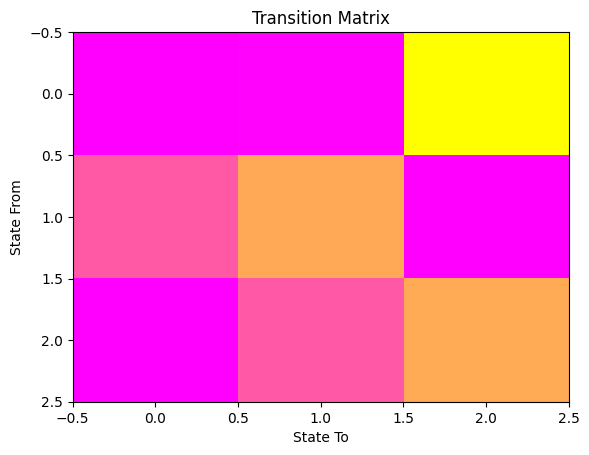

In [177]:
fig, ax = plt.subplots()
ax.imshow(model.transmat_, aspect='auto', cmap='spring')
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')

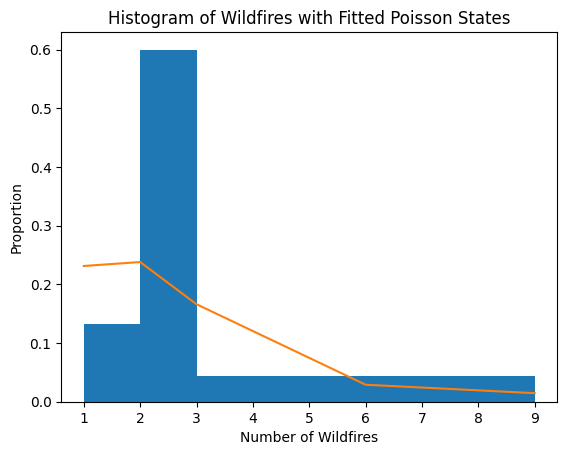

In [178]:
# get probabilities for each state given the data, take the average
# to find the proportion of time in that state
prop_per_state = model.predict_proba(data[:, None]).mean(axis=0)

# earthquake counts to plot
bins = sorted(np.unique(data))

fig, ax = plt.subplots()
ax.hist(data, bins=bins, density=True)
ax.plot(bins, poisson.pmf(bins, model.lambdas_).T @ prop_per_state)
ax.set_title('Histogram of Wildfires with Fitted Poisson States')
ax.set_xlabel('Number of Wildfires')
ax.set_ylabel('Proportion')

plt.show()

In [179]:
classes = ['A', 'B', 'C', 'D', 'E']
dfs = []

for c in classes:
    dfs.append(df.loc[df['SizeClass'] == c].groupby(['CalendarYear'])['CalendarYear'].count().rename(c+"_count"))

df3 = pd.concat([totalCount.rename('total_count')] + dfs,axis=1).fillna(0)
df3.columns



Index(['total_count', 'A_count', 'B_count', 'C_count', 'D_count', 'E_count'], dtype='object')

In [180]:
for c in classes:
    df3[c + "_prop"] = df3[c+'_count'] / df3['total_count']

df3

,total_count,A_count,B_count,C_count,D_count,E_count,A_prop,B_prop,C_prop,D_prop,E_prop
CalendarYear,,,,,,,,,,,
1997,2,1.0,1.0,0.0,0.0,0.0,0.500000,0.500000,0.000000,0.000000,0.000000
1998,2,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.500000,0.500000
1999,2,0.0,1.0,1.0,0.0,0.0,0.000000,0.500000,0.500000,0.000000,0.000000
2001,2,0.0,2.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
2004,2,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.500000
2005,9,2.0,2.0,0.0,2.0,1.0,0.222222,0.222222,0.000000,0.222222,0.111111
2006,3,1.0,1.0,0.0,0.0,1.0,0.333333,0.333333,0.000000,0.000000,0.333333
2007,2,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,0.500000,0.000000,0.500000
2008,2,0.0,1.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000


In [181]:
model.transmat_

array([[5.12992437e-07, 1.18776049e-02, 9.88121882e-01],
       [3.44669348e-01, 6.55327112e-01, 3.54044803e-06],
       [5.98914633e-04, 3.41039250e-01, 6.58361836e-01]])